In [2]:
import torch
import yaml
import shutil
from pathlib import Path
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
# /kaggle/working/
# /kaggle/input/indoor-object-detection

In [3]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 18.7 MB/s eta 0:00:0000:01


In [4]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [46]:
data_yaml = {
    "train": "/kaggle/input/indoor-object-detection/train/images",
    "val": "/kaggle/input/indoor-object-detection/test/images",
    "nc": 10,
    "names": [
        "door", "openedDoor", "cabinetDoor", "refrigeratorDoor",
        "window", "chair", "table", "cabinet", "couch", "pole"
    ]
}

with open("/kaggle/working/indoor_data.yaml", "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print("YAML config file created.")


YAML config file created.


**Візуалізація та аналіз**

In [31]:
class CFG:
    CUSTOM_DATASET_DIR = "/kaggle/input/indoor-object-detection"
    TRAIN_IMAGES_PATH = os.path.join(CUSTOM_DATASET_DIR, 'train/images')
    TEST_IMAGES_PATH = os.path.join(CUSTOM_DATASET_DIR, 'test/images')
    TRAIN_LABELS_PATH = os.path.join(CUSTOM_DATASET_DIR, 'train/labels')
    TEST_LABELS_PATH = os.path.join(CUSTOM_DATASET_DIR, 'test/labels')
    SEED = 42
    CLASSES = data_yaml["names"]
    NUM_CLASSES_TO_TRAIN = data_yaml["nc"]

CFG.CUSTOM_DATASET_DIR

'/kaggle/input/indoor-object-detection'

In [14]:
def display_image(image, print_info=True, hide_axis=False):
    if isinstance(image, str):
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):
        image = image[..., ::-1]
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (682, 1024, 3) 



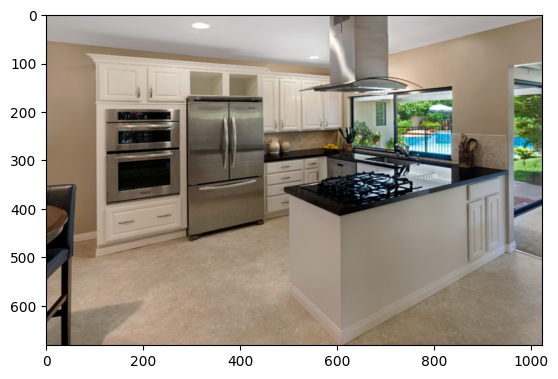

In [32]:
example_image_path = os.path.join(CFG.TRAIN_IMAGES_PATH, os.listdir(images_path)[0])
display_image(example_image_path, print_info=True, hide_axis=False)

In [34]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):
    random.seed(seed)
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")
    selected_files = random.sample(image_files, num_images)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    for i, file_name in enumerate(selected_files):
        img = Image.open(os.path.join(folder_path, file_name))
        ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
        ax.imshow(img)
        ax.axis('off')
    for i in range(num_images, num_rows * num_cols):
        fig.delaxes(axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols])
    plt.tight_layout()
    plt.show()

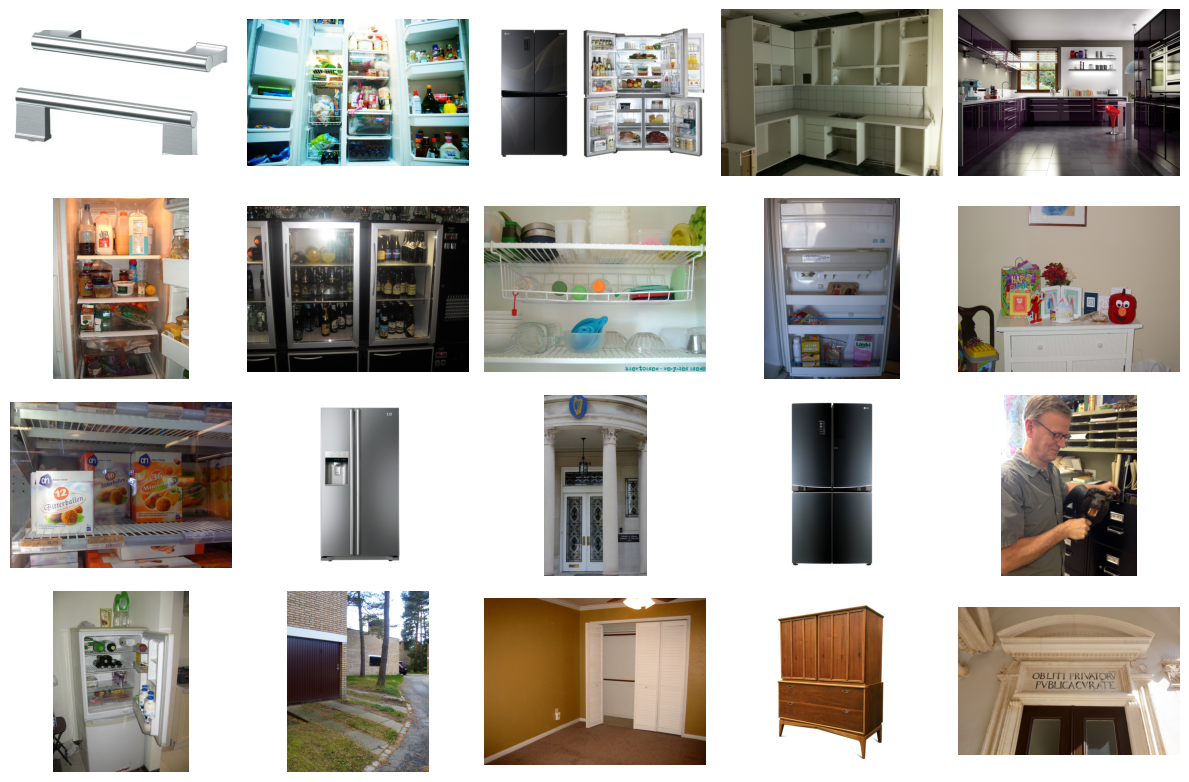

In [35]:
plot_random_images_from_folder(CFG.TRAIN_IMAGES_PATH)

In [37]:
def get_image_properties(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Could not read image file")
    return {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

In [40]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 1024, 'height': 682, 'channels': 3, 'dtype': dtype('uint8')}

In [43]:
def check_dataset_consistency(folder_path):
    print(f"Checking images in: {folder_path}")
    mismatched = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder_path, filename)
            try:
                props = get_image_properties(path)
                if props["channels"] != 3 or props["dtype"] != np.uint8:
                    mismatched.append((filename, props))
            except Exception as e:
                print(f"Error reading {filename}: {e}")
    if mismatched:
        print("\n⚠️ Inconsistent images found:")
        for name, props in mismatched:
            print(f" - {name}: {props}")
    else:
        print("✅ All images have 3 channels and uint8 dtype.")

check_dataset_consistency(CFG.TRAIN_IMAGES_PATH)
check_dataset_consistency(CFG.TEST_IMAGES_PATH)

Checking images in: /kaggle/input/indoor-object-detection/train/images
✅ All images have 3 channels and uint8 dtype.
Checking images in: /kaggle/input/indoor-object-detection/test/images
✅ All images have 3 channels and uint8 dtype.


,Mode,door,openedDoor,cabinetDoor,refrigeratorDoor,window,chair,table,cabinet,couch,pole,Data_Volume
0,train,309,448,332,187,105,165,138,22,68,14,1008
1,test,25,42,1,49,38,41,44,31,18,3,104


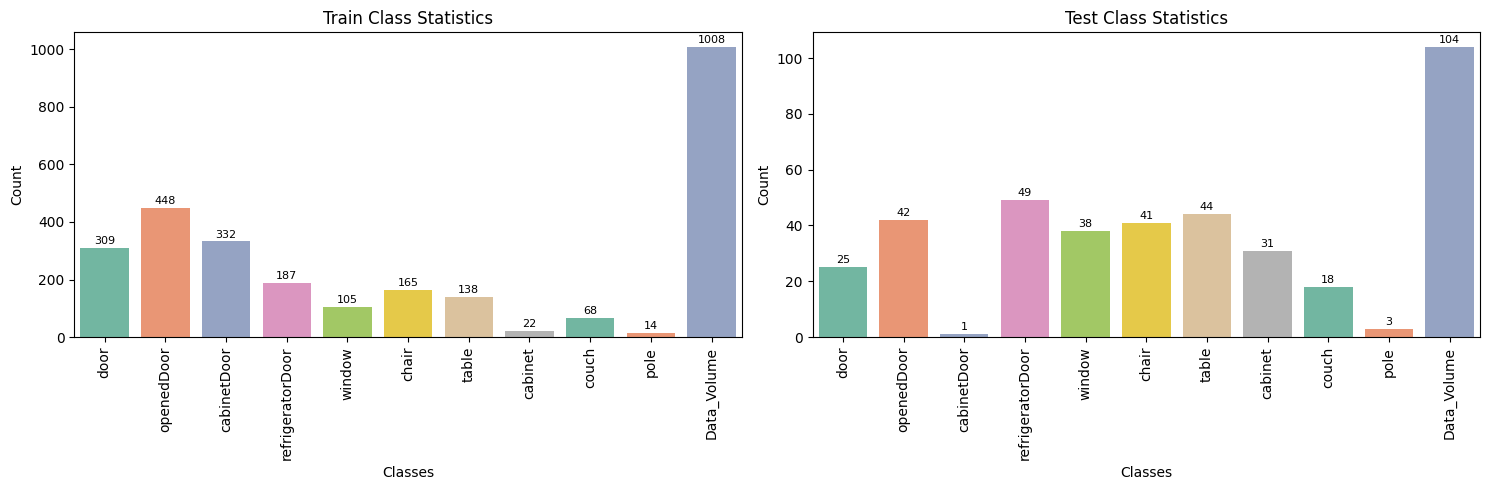

In [44]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}
class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}
    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')
    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()
            for cls in set([line.strip().split()[0] for line in lines]):
                if cls in class_idx:
                    class_count[class_idx[cls]] += 1
    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count
    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None): 
    display(dataset_stats_df)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, mode in enumerate(['train', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')
plt.tight_layout()
plt.show()

**Навчання моделі**

In [47]:
model = YOLO("yolov9s.pt")

In [51]:
model.train(
    data="/kaggle/working/indoor_data.yaml",
    epochs=50,
    batch=16,
    imgsz=640,
    device=device,
    workers=4,
    project="runs/train",
    name="yolo_indoor",
    save=True
)

engine/trainer: task=detect, mode=train, model=yolov9s.pt, data=/kaggle/working/indoor_data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=runs/train, name=yolo_indoor4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimi

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.7MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/indoor-object-detection/train/labels... 1008 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1012/1012 [00:01<00:00, 804.24it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/input/indoor-object-detection/test/labels... 104 images, 3 backgrounds, 0 corrupt: 100%|██████████| 107/107 [00:00<00:00, 470.30it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/test is not writeable, cache not saved.


Plotting labels to runs/train/yolo_indoor4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/train/yolo_indoor4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.93G       1.65      2.903      1.616         40        640: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        107        550      0.636      0.179      0.198     0.0962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.35G      1.462      1.899      1.432         23        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        107        550      0.319      0.281      0.125      0.054



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.35G      1.464      1.797      1.421         22        640: 100%|██████████| 64/64 [00:25<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        107        550      0.511      0.271      0.141      0.064



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.35G      1.484      1.779       1.46         41        640: 100%|██████████| 64/64 [00:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        107        550      0.426      0.276      0.177      0.084



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.35G      1.468      1.724      1.444         31        640: 100%|██████████| 64/64 [00:24<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

                   all        107        550      0.319      0.214      0.111     0.0509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.35G      1.414      1.608      1.408         24        640: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        107        550      0.405      0.198      0.207      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.35G      1.419      1.553       1.41         49        640: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        107        550      0.326      0.294      0.241      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.35G      1.395      1.506      1.407         28        640: 100%|██████████| 64/64 [00:25<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

                   all        107        550      0.558      0.267      0.232      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.35G        1.4      1.497      1.408         22        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        107        550      0.425      0.275      0.276      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.35G      1.376      1.419      1.392         36        640: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        107        550      0.416      0.313      0.276      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.35G      1.359      1.411      1.379         64        640: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        107        550      0.295      0.302      0.225      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.35G      1.341      1.388      1.368         41        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all        107        550      0.389      0.303      0.308       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.35G      1.318      1.316      1.349         32        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        107        550      0.472       0.23      0.223      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.35G       1.32      1.315      1.363         29        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        107        550      0.392      0.354      0.301      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.35G      1.299      1.256      1.339         31        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        107        550      0.318      0.357      0.286      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.35G      1.319      1.247       1.34         67        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        107        550      0.513      0.306      0.339      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.35G      1.291      1.213      1.343         12        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all        107        550      0.515        0.3      0.312      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.35G      1.269      1.176      1.324         58        640: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        107        550      0.666      0.192      0.309      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.35G      1.259      1.147        1.3         60        640: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        107        550      0.431      0.379      0.401      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.35G       1.26      1.162      1.296         25        640: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


                   all        107        550      0.523      0.367      0.337      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.35G       1.25      1.086      1.294         40        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all        107        550      0.443      0.364      0.305      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.35G       1.23      1.085      1.311         16        640: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]

                   all        107        550      0.377      0.377       0.32      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.35G      1.205      1.046      1.289         42        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]

                   all        107        550      0.385       0.37      0.302      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.35G      1.225      1.042      1.288         27        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        107        550       0.46      0.371      0.342       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.35G      1.199      1.025      1.288         32        640: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]

                   all        107        550      0.339      0.443       0.37      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.35G      1.185     0.9851      1.262         25        640: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all        107        550      0.457      0.327      0.327      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.35G      1.168     0.9559       1.27         45        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

                   all        107        550      0.578      0.317      0.373      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.35G      1.184     0.9373      1.258         47        640: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all        107        550      0.387      0.398       0.39      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.35G      1.177     0.9125       1.24         33        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        107        550      0.416      0.354      0.374      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.35G      1.156     0.9073      1.241         36        640: 100%|██████████| 64/64 [00:25<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]

                   all        107        550      0.397      0.364       0.37      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.35G      1.154     0.8854      1.239         22        640: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]

                   all        107        550      0.651      0.269       0.37      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.35G      1.148     0.8705      1.228         34        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        107        550      0.482       0.37      0.383       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.35G      1.122     0.8486      1.216         52        640: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

                   all        107        550      0.455      0.376      0.391      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.35G      1.093     0.8305      1.217         46        640: 100%|██████████| 64/64 [00:25<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        107        550      0.381      0.388      0.363      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.35G      1.089     0.8077      1.196         41        640: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]

                   all        107        550       0.39      0.347      0.351      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.35G      1.095     0.8041      1.208         75        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]

                   all        107        550       0.54      0.332      0.398      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.35G       1.08     0.7758      1.208         31        640: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        107        550      0.521      0.313      0.352        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.35G       1.08     0.7713      1.199         29        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all        107        550      0.458       0.37      0.393      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.35G      1.072     0.7576      1.194        123        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        107        550      0.401      0.422      0.366      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.35G      1.054     0.7582      1.184         54        640: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        107        550      0.499      0.399      0.383      0.219


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.35G      1.046     0.7357      1.184          5        640: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all        107        550      0.404        0.4      0.326      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.35G      1.032     0.6444       1.18          7        640: 100%|██████████| 64/64 [00:24<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        107        550       0.43       0.39      0.407      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.35G      1.012     0.6198      1.161          7        640: 100%|██████████| 64/64 [00:25<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        107        550      0.537      0.372      0.413      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.35G     0.9997     0.5868      1.158          9        640: 100%|██████████| 64/64 [00:25<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

                   all        107        550       0.53      0.375      0.406      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.35G     0.9988     0.5911      1.151         59        640: 100%|██████████| 64/64 [00:24<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

                   all        107        550      0.463      0.386      0.399      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.35G     0.9805     0.5615      1.156         26        640: 100%|██████████| 64/64 [00:24<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all        107        550      0.588      0.358      0.419      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.35G     0.9621     0.5474      1.134         29        640: 100%|██████████| 64/64 [00:24<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        107        550      0.533      0.397      0.416      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.35G     0.9548       0.55      1.136         14        640: 100%|██████████| 64/64 [00:24<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

                   all        107        550      0.546       0.37      0.409      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.35G     0.9488     0.5358      1.128         25        640: 100%|██████████| 64/64 [00:24<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        107        550      0.511      0.381      0.414       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.35G     0.9377     0.5309      1.121         15        640: 100%|██████████| 64/64 [00:24<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        107        550       0.51      0.391      0.409      0.234



50 epochs completed in 0.383 hours.
Optimizer stripped from runs/train/yolo_indoor4/weights/last.pt, 15.2MB
Optimizer stripped from runs/train/yolo_indoor4/weights/best.pt, 15.2MB

Validating runs/train/yolo_indoor4/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9s summary (fused): 197 layers, 7,170,958 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


                   all        107        550       0.52       0.38      0.414       0.24
                  door         25         34      0.423      0.353      0.386       0.24
            openedDoor         42        179      0.604      0.542      0.518      0.206
           cabinetDoor          1          2      0.434          1      0.995      0.696
      refrigeratorDoor         49         63      0.662      0.556      0.588      0.367
                window         38         87      0.578      0.362      0.409      0.232
                 chair         41         47       0.39      0.299      0.283      0.154
                 table         44         52      0.555      0.192      0.283      0.178
               cabinet         31         58      0.299      0.121      0.152     0.0701
                 couch         18         20      0.766       0.25      0.334      0.126
                  pole          3          8      0.492      0.125      0.196      0.129


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 5.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/train/yolo_indoor4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79fb8a0f6110>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

**Оцінка моделі**

In [52]:
results = model.val()
print("Evaluation Metrics:")
print(results)

Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9s summary (fused): 197 layers, 7,170,958 parameters, 0 gradients, 26.7 GFLOPs


val: Scanning /kaggle/input/indoor-object-detection/test/labels... 104 images, 3 backgrounds, 0 corrupt: 100%|██████████| 107/107 [00:00<00:00, 471.02it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


                   all        107        550      0.519      0.381      0.415      0.239
                  door         25         34      0.424      0.353      0.377      0.233
            openedDoor         42        179      0.611      0.547      0.522      0.206
           cabinetDoor          1          2      0.436          1      0.995      0.696
      refrigeratorDoor         49         63      0.678      0.569      0.587      0.367
                window         38         87       0.57      0.356      0.408      0.232
                 chair         41         47       0.39        0.3      0.283      0.151
                 table         44         52      0.526      0.192      0.283      0.178
               cabinet         31         58      0.299      0.121      0.152     0.0702
                 couch         18         20      0.778       0.25      0.345      0.131
                  pole          3          8      0.482      0.125      0.197       0.13


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 2.1ms preprocess, 10.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/train/yolo_indoor42
Evaluation Metrics:
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79fb8a576860>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0

**Аналіз результатів**

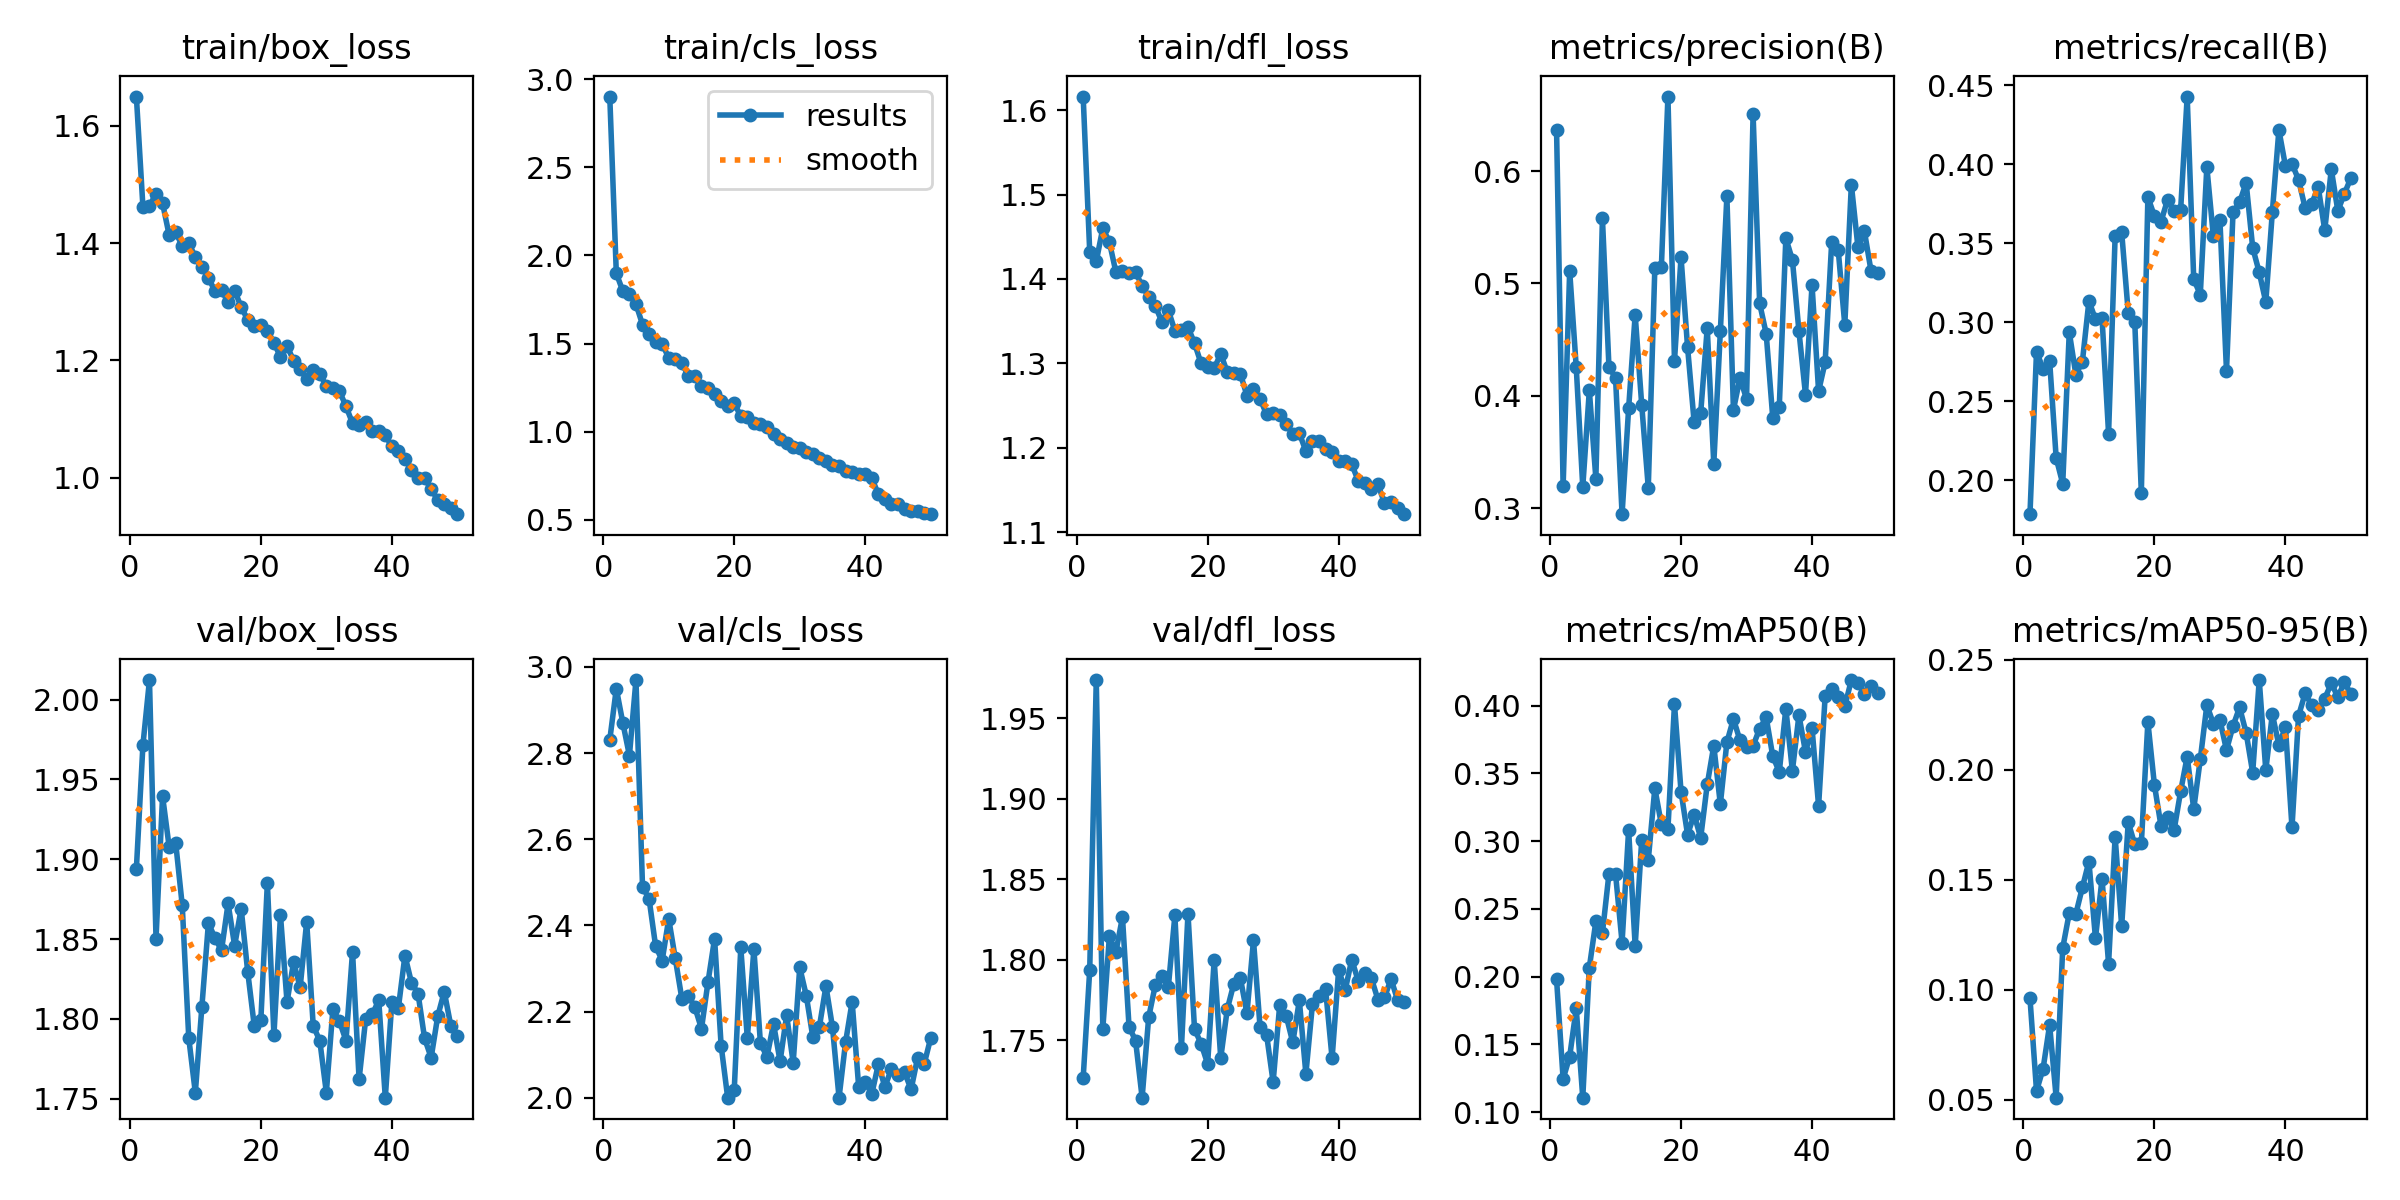

In [60]:
from ultralytics.utils.plotting import plot_results
from IPython.display import Image, display
plot_results(file='runs/train/yolo_indoor4/results.csv')
display(Image(filename='runs/train/yolo_indoor4/results.png'))
plt.show()

In [61]:
model.predict(source=CFG.TEST_IMAGES_PATH, save_txt=False, save_conf=True, conf=0.25)


image 1/107 /kaggle/input/indoor-object-detection/test/images/1003.png: 480x640 3 doors, 1 couch, 66.2ms
image 2/107 /kaggle/input/indoor-object-detection/test/images/1014.png: 480x640 (no detections), 17.8ms
image 3/107 /kaggle/input/indoor-object-detection/test/images/1015.png: 480x640 (no detections), 17.7ms
image 4/107 /kaggle/input/indoor-object-detection/test/images/1020.png: 480x640 1 refrigeratorDoor, 1 couch, 17.6ms
image 5/107 /kaggle/input/indoor-object-detection/test/images/1021.png: 480x640 (no detections), 16.9ms
image 6/107 /kaggle/input/indoor-object-detection/test/images/1023.png: 480x640 1 cabinetDoor, 1 refrigeratorDoor, 2 windows, 16.8ms
image 7/107 /kaggle/input/indoor-object-detection/test/images/1026.png: 480x640 3 doors, 1 refrigeratorDoor, 1 cabinet, 17.0ms
image 8/107 /kaggle/input/indoor-object-detection/test/images/1027.png: 480x640 1 chair, 1 cabinet, 16.9ms
image 9/107 /kaggle/input/indoor-object-detection/test/images/1028.png: 480x640 1 door, 1 window, 2

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'door', 1: 'openedDoor', 2: 'cabinetDoor', 3: 'refrigeratorDoor', 4: 'window', 5: 'chair', 6: 'table', 7: 'cabinet', 8: 'couch', 9: 'pole'}
 obb: None
 orig_img: array([[[ 20,  23,  39],
         [ 21,  23,  41],
         [ 24,  26,  45],
         ...,
         [ 41,  72, 102],
         [ 40,  71, 102],
         [ 40,  69, 103]],
 
        [[ 20,  22,  40],
         [ 21,  23,  41],
         [ 24,  25,  45],
         ...,
         [ 42,  73, 103],
         [ 43,  72, 103],
         [ 43,  70, 104]],
 
        [[ 21,  22,  42],
         [ 22,  24,  43],
         [ 26,  27,  47],
         ...,
         [ 43,  74, 104],
         [ 44,  73, 104],
         [ 44,  71, 105]],
 
        ...,
 
        [[ 29,  40,  59],
         [ 50,  59,  78],
         [ 84,  90, 109],
         ...,
         [129, 145, 197],
         [126, 143, 199],
         

In [69]:
if hasattr(results, 'names') and hasattr(results, 'box'):
    class_names = results.names
    p = results.box.p  # precision per class
    r = results.box.r  # recall per class
    f1 = results.box.f1  # f1 score per class
    ap50 = results.box.ap50  # AP@0.5 IoU per class
    ap = results.box.ap  # AP@0.5:0.95 IoU per class

    print("\nPer-class evaluation metrics:")
    for i, name in class_names.items():
        print(f"Class: {name:15s} | Precision: {p[i]:.2f} | Recall: {r[i]:.2f} | F1-score: {f1[i]:.2f} | AP@0.5: {ap50[i]:.2f} | AP@0.5:0.95: {ap[i]:.2f}")
else:
    print("Detailed per-class metrics not available in this version of Ultralytics.")


Per-class evaluation metrics:
Class: door            | Precision: 0.42 | Recall: 0.35 | F1-score: 0.39 | AP@0.5: 0.38 | AP@0.5:0.95: 0.23
Class: openedDoor      | Precision: 0.61 | Recall: 0.55 | F1-score: 0.58 | AP@0.5: 0.52 | AP@0.5:0.95: 0.21
Class: cabinetDoor     | Precision: 0.44 | Recall: 1.00 | F1-score: 0.61 | AP@0.5: 0.99 | AP@0.5:0.95: 0.70
Class: refrigeratorDoor | Precision: 0.68 | Recall: 0.57 | F1-score: 0.62 | AP@0.5: 0.59 | AP@0.5:0.95: 0.37
Class: window          | Precision: 0.57 | Recall: 0.36 | F1-score: 0.44 | AP@0.5: 0.41 | AP@0.5:0.95: 0.23
Class: chair           | Precision: 0.39 | Recall: 0.30 | F1-score: 0.34 | AP@0.5: 0.28 | AP@0.5:0.95: 0.15
Class: table           | Precision: 0.53 | Recall: 0.19 | F1-score: 0.28 | AP@0.5: 0.28 | AP@0.5:0.95: 0.18
Class: cabinet         | Precision: 0.30 | Recall: 0.12 | F1-score: 0.17 | AP@0.5: 0.15 | AP@0.5:0.95: 0.07
Class: couch           | Precision: 0.78 | Recall: 0.25 | F1-score: 0.38 | AP@0.5: 0.34 | AP@0.5:0.95: 0

In [ ]:
best_weights_path = "runs/train/yolo_indoor/weights/best.pt"
print(f"Best model weights saved at: {best_weights_path}")

# Висновки

1. Аналіз отриманих результатів

**Чому модель не завжди могла досягти очікуваних показників:**

- Нерівномірний розподіл класів у тренувальних даних:
    - Наприклад, клас cabinetDoor має лише 2 приклади, а openedDoor — 179. Це призводить до переобучення на частих класах і поганого узагальнення на рідкісних.

- Нестача зображень в окремих класах (наприклад, pole — 8 інстансів): модель просто не встигає "навчитись", як вони виглядають.

- Схожість класів (наприклад, cabinet, cabinetDoor, refrigeratorDoor) — модель плутає їх через подібність форми, кольору та контексту.

2. Oцінка архітектури YOLOv9s

Це легка версія YOLOv9, яка добре підходить для початкового аналізу і навчання на обмеженому обсязі даних.

Швидке навчання, підтримка MPS, CUDA, Colab, і зручний API через ultralytics.

- Недоліки YOLOv9s у цьому контексті:

    - Недостатня глибина та параметри для складних об’єктів або зображень із великою кількістю об'єктів.

    - Не враховує контекст сцени (наприклад, холодильник частіше біля кухні, а стіл біля стільця).

    - Без попереднього підсилення даних (augmentation) модель вчиться дуже "буквально".

3. Пропозиції щодо покращення

**Оптимізація моделі:**

- Data augmentation: додати повороти, перевороти, зміни яскравості/контрасту. Це суттєво збільшить варіативність вхідних даних.

- Підвищення розміру зображень: наприклад, imgsz=768 або 960 — покращить якість рамок (особливо для дрібних об’єктів).

- Спробувати більшу архітектуру, наприклад yolov9m.pt або yolov8m.pt.

**Покращення даних:**

- Балансування класів: або розширити набір для класів pole, cabinet, couch, або застосувати oversampling.

- Фільтрація “шуму”: видалити зображення, де об'єкти майже не видно, або дуже затемнені.
